Here we shall implement the model of "A Neural Probabilistic Language Model" of Bengio et. al. 2003, see https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf. We construct class objects for our model mimicking PyTorch Sequentianal container and layers. We buid a batch normalisation layer following the 2015 paper of Ioffe and Szegedy, see https://arxiv.org/abs/1502.03167.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [2]:

# load a list of popular names
words = open('names.txt','r').read().splitlines()
print(f'total of {len(words)} names')
words[:10]

total of 32033 names


['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words)))) # get a sorted list of unique characters in words

# get a mapping of characters to their indices, then add start/end special token
s_to_i = {s : i+1 for i,s in enumerate(chars)}
s_to_i['.'] = 0 

# invert s_to_i
i_to_s = {i : s for s,i in s_to_i.items()}
vocab_size = len(s_to_i)
print(i_to_s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
# build the dataset

def build_dataset(words, block_size = 3):
    
    # block_size is the context length: number of charachters we consider to predict the next one
    X, Y = [], []

    for w in words:
        context = [0] * block_size # create the sliding window, context filled with '.'

        # loop over charachters in the word w
        for char in w + '.':
            ix = s_to_i[char] # get the index of character char
            X.append(context) # add the 
            Y.append(ix) # add char index to the sequence
    #         print(''.join(i_to_s[i] for i in context), '--->', i_to_s[ix]) # print the context and the next character
            context = context[1:] + [ix] # crop the old context and add the next character
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, X.dtype, Y.shape, Y.dtype)
    return X, Y

In [5]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(.8*len(words))
n2 = int(.9*len(words))

block_size = 5

# build train, validation and test datasets
X_train, Y_train = build_dataset(words[:n1], block_size = block_size)
X_val, Y_val = build_dataset(words[n1:n2], block_size = block_size)
X_test, Y_test = build_dataset(words[n2:], block_size = block_size)

torch.Size([182625, 5]) torch.int64 torch.Size([182625]) torch.int64
torch.Size([22655, 5]) torch.int64 torch.Size([22655]) torch.int64
torch.Size([22866, 5]) torch.int64 torch.Size([22866]) torch.int64


In [6]:
torch.manual_seed(42)

First, we implement the Bengio et. al. model. The model has three layers. The first is the embedding layer, which allows to learn similiarities between different characters, see e.g. Goodfellow et. al. The other two layers are the linear transformation layer and the hyperbolic tangent nonlinearity layer.

In [7]:
class Embedding:
    
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, ix):
        self.out = self.weight[ix] 
        return self.out
    
    def parameters(self):
        return []  
    
class Flatten:
        
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    
    def parameters(self):
        return []

In [8]:
class Linear:
    # Linear transformation neural layer
    def __init__(self, n_in, n_out, bias = True):
        self.weight = torch.randn((n_in, n_out)) / n_in**.5 # Kaiming initialisation
        self.bias = torch.zeros(n_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight 
        
        if self.bias is not None:
            self.out += self.bias
            
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [9]:
class Tanh:
    # tanh non-lineraity layer
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

Next, we implement the batch normalisation layer. We do so as follows. Let $x = (x_1, \ldots, x_n)$ be the input to the layer. We standardise the input layers as 
\begin{align}
    \hat{x}_i \leftarrow \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma_{\mathcal{B}}^2 + \varepsilon}}
    ,
\end{align}
where $\mu_{\mathcal{B}} = \frac{1}{n} \sum_{i=1}^n x_i $ and $\sigma_{\mathcal{B}}^2 = \frac{1}{n+1} \sum_{i=1}^n ( x_i - \mu_{\mathcal{B}})^2$ are the batch mean and batch variance, respectively, and $\varepsilon$ is a small constant added for numerical stability. Note, that we deviate from the original paper and choose to use the unbiased estimator for the variance. Then, we scale the resulting standardised input by $\gamma$ and shift it by $\beta$ as
\begin{align}
    \text{output}_i \leftarrow \gamma  \hat{x}_i + \beta
    .
\end{align}
Note, that the latter shift effecively eliminates the need for the bias parameter in the Linear layer.

In [10]:
class BatchNorm1d:
    # batch normalisation layer
    def __init__(self, dim, eps = 1e-05, momentum = .1):
        
        self.eps = eps
        self.momentum = momentum
        self.training = True # distinguish between batchnorm for training and for evaluation modes
        
        # parameter trained with backpropogation
        self.gamma = torch.ones(dim) # scale parameter
        self.beta = torch.zeros(dim) # shift parameter
        
        # buffers trained with 'momentum update'
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # forward pass
        if self.training == True:
            x_mean = x.mean(0, keepdim = True) # use batch mean
            x_var = x.var(0, keepdim = True) # use batch variance
        else:
            x_mean = self.running_mean
            x_var = self.running_var
            
        x_hat = (x - x_mean)/torch.sqrt(x_var + self.eps) # standardise
        self.out = self.gamma * x_hat + self.beta 
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * x_var
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
class Sequential:
    # container for the layers
    def __init__(self, layers):
        self.layers = layers
        
    def __repr__(self):
        return f'Sequential model, number of layers: {len(self.layers)}, number of parameters: {sum([p.numel() for layer in self.layers for p in layer.parameters()])}'
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def add(self, layer):
        self.layers.append(layer)
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [12]:
n_embd = 15
n_hidden = 200

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), 
    BatchNorm1d(n_hidden), 
    Tanh(),
    Linear(n_hidden, vocab_size)]) 

print(f'number of parameters: { sum([p.numel() for layer in model.layers for p in layer.parameters()])}')

with torch.no_grad():
    model.layers[-1].weight *= .1
    
for p in model.parameters(): 
    p.requires_grad = True

number of parameters: 20827


In [13]:
lossi = []
batch_size = 32
def train(X, Y, n_epochs = 10000, lr = .1, verbose = True):
    for i in range(n_epochs):
        # minibatch construct
        ix = torch.randint(0, X_train.shape[0], (batch_size,))
        X_batch, Y_batch = X_train[ix], Y_train[ix]
        
        # forward pass
        logits = model(X_batch)
        
        loss = F.cross_entropy(logits, Y_batch) # compute the loss
        
        # backward pass
        for p in model.parameters():
            p.grad = None

        loss.backward()
        
        # update
        lr = lr if i < int(n_epochs/1.5) else lr/10 # lower learning rate for the end of training
        
        for p in model.parameters():
            p.data += -lr * p.grad
            
        # track stats
        if verbose and i % 10000 == 0: # print the loss every once in a while
            print(f'{i:7d}/{n_epochs:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
        
    print(f'epoch {n_epochs:7d}/{n_epochs:7d}: {loss.item():.4f}')

In [14]:
n_epochs = 200000

train(X_train, Y_train, n_epochs = n_epochs)

      0/ 200000: 3.3066
  10000/ 200000: 1.8110
  20000/ 200000: 1.8158
  30000/ 200000: 2.6247
  40000/ 200000: 2.4269
  50000/ 200000: 2.2451
  60000/ 200000: 2.0184
  70000/ 200000: 1.9842
  80000/ 200000: 2.0814
  90000/ 200000: 2.0417
 100000/ 200000: 1.9373
 110000/ 200000: 2.1570
 120000/ 200000: 2.0054
 130000/ 200000: 2.4627
 140000/ 200000: 2.0988
 150000/ 200000: 2.1580
 160000/ 200000: 1.8792
 170000/ 200000: 1.9016
 180000/ 200000: 2.0292
 190000/ 200000: 2.5036
 200000/ 200000: 2.0950


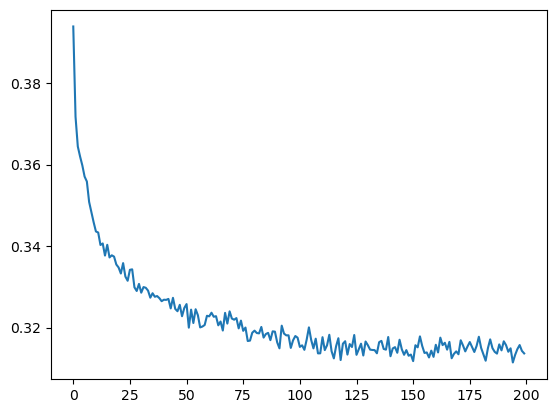

In [15]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [16]:
for layer in model.layers:
    print(layer.__class__.__name__,':', tuple(layer.out.shape))

Embedding : (32, 5, 15)
Flatten : (32, 75)
Linear : (32, 200)
BatchNorm1d : (32, 200)
Tanh : (32, 200)
Linear : (32, 27)


In [17]:
for layer in model.layers:
    layer.training = False

In [18]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
split_loss('train')
split_loss('val')
split_loss('test')

train 2.0433852672576904
val 2.1237926483154297
test 2.1199307441711426


In [19]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
      # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
      # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(i_to_s[i] for i in out)) # decode and print the generated word

jaciel.
milla.
maylee.
darhon.
lecse.
zohenicole.
sylahak.
derianvioa.
adelynn.
juli.
madelinn.
ariheo.
milliani.
evania.
irakelleany.
kolana.
igonn.
sardon.
maria.
arfa.
